# TP 1: Comparaison d'algorithmes itératif pour minimiser un modèle de débruitage d'image


Nous allons, lors de ce TP, comparer les performances des algorithmes vus en
cours. Pour cela, nous considérerons un problème de débruitage: notre donnée
est de la forme
\[v=u+b,
\]
où $u\in {\mathbb R}^{N^2}$ est l'image que l'on cherche, $v\in {\mathbb R}^{N^2}$ est la
donnée à notre disposition et $b\in {\mathbb R}^{N^2}$ est la réalisation d'un bruit
blanc Gaussien.

Le modèle que l'on cherchera à résoudre consiste à minimiser l'énergie
$$E(w)=\sum_{i,j=0}^{N-1} |\nabla w_{i,j}|^2 + \lambda \sum_{i,j=0}^{N-1}
(w_{i,j}-v_{i,j})^2,
$$
pour $w\in {\mathbb R}^{N^2}$ et $\lambda \geq 0$, avec
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots,N-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).

Ce TP porte sur le problème étudié dans le TD 1, exercice 2. Les notations (notammment l'opérateur $B$) sont décrites dans cet exercice.




## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




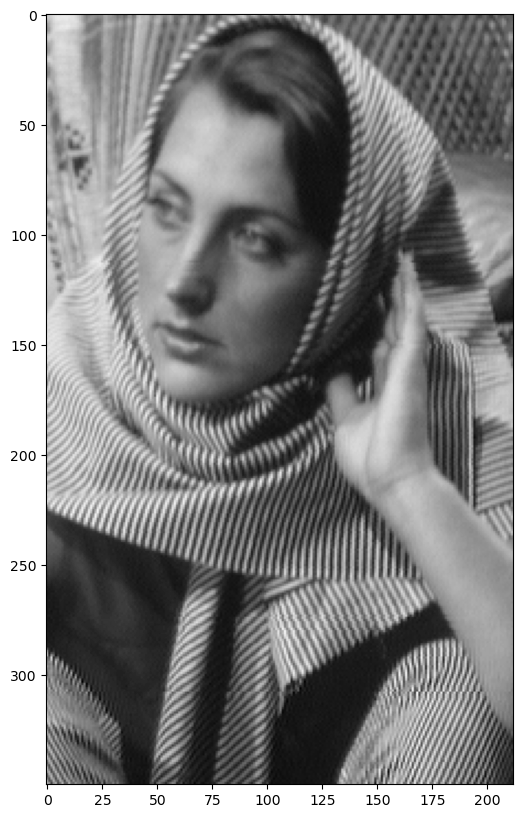

In [2]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:550]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction faisant un calcul exact du minimiseur

In [3]:
def quadratique_exacte(v,Lambda):

    fftV = np.fft.fft2(v)
    fftOut=np.copy(fftV)
   
    sx , sy = np.shape(v)
    for x in range(sx):
        for y in range(sy):
            fftOut[x][y]= Lambda * fftV[x][y]/(Lambda + 4 - 2*(math.cos(2*math.pi*x/sx)+math.cos(2*math.pi*y/sy)))
    
    out =  np.fft.ifft2(fftOut) 
    out = out.real

    return out

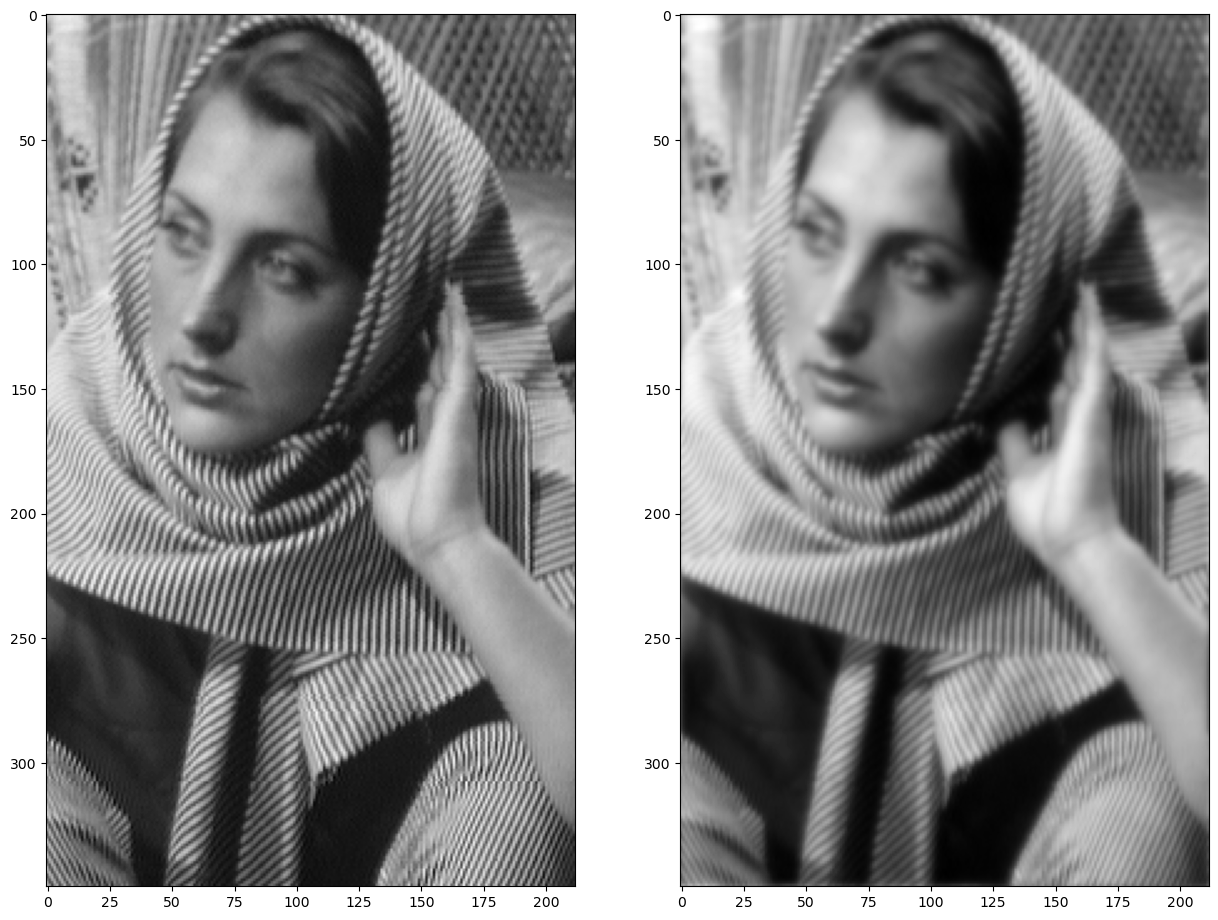

In [4]:
v = u
Lambda=1
out = quadratique_exacte(v,Lambda)

plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out,cmap='gray')



## Fonction calculant itérativement le minimiseur

In [5]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')

def grad_E(out,v,Lambda):
    tmpx = grad_x(out,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(out,0)
    tmpy1 = grad_y(tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1 + Lambda * (out-v)) 
    
    return grad

def E(out,v,Lambda):
    sx , sy = np.shape(out)
    gx = np.linalg.norm( grad_x(out,0), ord='fro')
    gy = np.linalg.norm( grad_y(out,0), ord='fro')
    data = np.linalg.norm( out - v , ord='fro')
    
    return (gx*gx + gy*gy + Lambda *data*data)/(sx*sy)

def quadratique_approx(v,Lambda,nbIter):
    pas = 0.05
    out_exacte = quadratique_exacte(v,Lambda)
    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)
#    out = out_exacte               # initialisation proche sur la solution (pour tester)
    
    for it in range(nbIter):
        d = grad_E(out,v,Lambda)
        out = out - pas * d
        print( 'iter = ', it , 'fonction = ' , E(out,v,Lambda), 'norm grad =',\
               np.linalg.norm(d), 'distance a la solution = ', np.linalg.norm(out-out_exacte)  )
        
    return out

-164728.90078420728  =  -164728.900784209  ?
-31610736.0  =  -31610736.0  ?
26782.640215649313  =  26782.64021564932  ?
-10161156.0  =  -10161156.0  ?


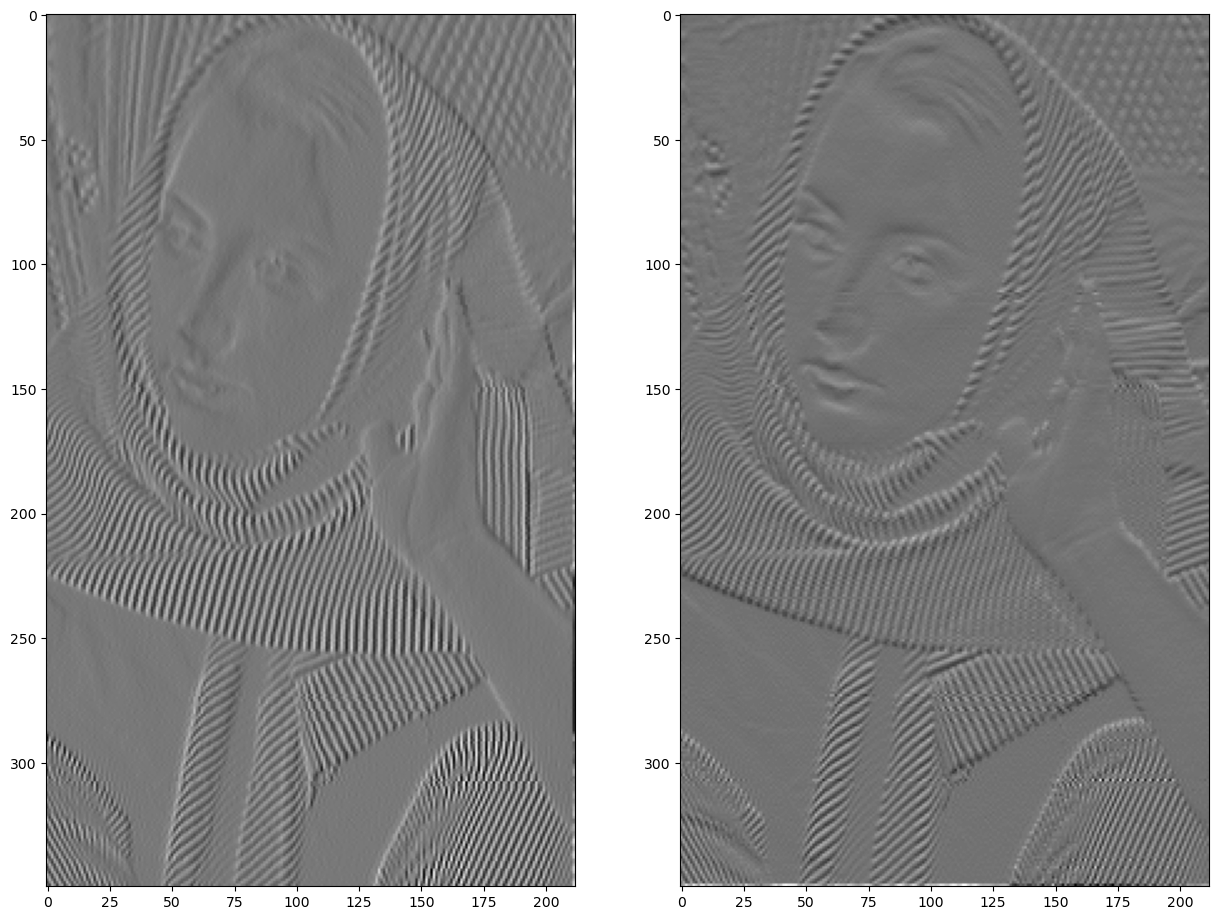

In [6]:
# Debug les differences finies
v = u
verifie_grad_y(u,np.random.normal(100,10,np.shape(u)))
verifie_grad_y(u,v)
dy = grad_y(v, 0)

verifie_grad_x(u,np.random.normal(100,10,np.shape(u)))
verifie_grad_x(u,v)
dx = grad_x(v, 0)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(dy,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dx,cmap='gray')




iter =  0 fonction =  624.8891150799924 norm grad = 30912.447 distance a la solution =  2486.6624465226746
iter =  1 fonction =  457.32862040034604 norm grad = 17613.443 distance a la solution =  1666.4627459129767
iter =  2 fonction =  393.70035777736626 norm grad = 10757.098 distance a la solution =  1170.9008249471979
iter =  3 fonction =  367.3959932632684 norm grad = 6865.34 distance a la solution =  858.8984537907661
iter =  4 fonction =  355.6975117386456 norm grad = 4546.45 distance a la solution =  654.6788826729837
iter =  5 fonction =  350.12120731194705 norm grad = 3117.0935 distance a la solution =  515.4833000924057
iter =  6 fonction =  347.2755970732936 norm grad = 2211.1338 distance a la solution =  416.5648425415496
iter =  7 fonction =  345.7236687985649 norm grad = 1621.7499 distance a la solution =  343.3810998689934
iter =  8 fonction =  344.82284110154825 norm grad = 1227.7468 distance a la solution =  287.2606582306645
iter =  9 fonction =  344.270063109912 norm

iter =  78 fonction =  343.0848205594562 norm grad = 0.120425954 distance a la solution =  0.04962943228816272
iter =  79 fonction =  343.08483067639753 norm grad = 0.10757739 distance a la solution =  0.04434354265845594
iter =  80 fonction =  343.08484079335335 norm grad = 0.096164614 distance a la solution =  0.039633013089931654
iter =  81 fonction =  343.08485091032367 norm grad = 0.08602707 distance a la solution =  0.03543251654331093
iter =  82 fonction =  343.08483631319837 norm grad = 0.077010185 distance a la solution =  0.031694616974281706
iter =  83 fonction =  343.0848340731305 norm grad = 0.06900924 distance a la solution =  0.02835873726908106
iter =  84 fonction =  343.08485878724696 norm grad = 0.061905373 distance a la solution =  0.0253932511612381
iter =  85 fonction =  343.08483071304073 norm grad = 0.055605862 distance a la solution =  0.022758292135801127
iter =  86 fonction =  343.08482959301404 norm grad = 0.050046477 distance a la solution =  0.0204199183780

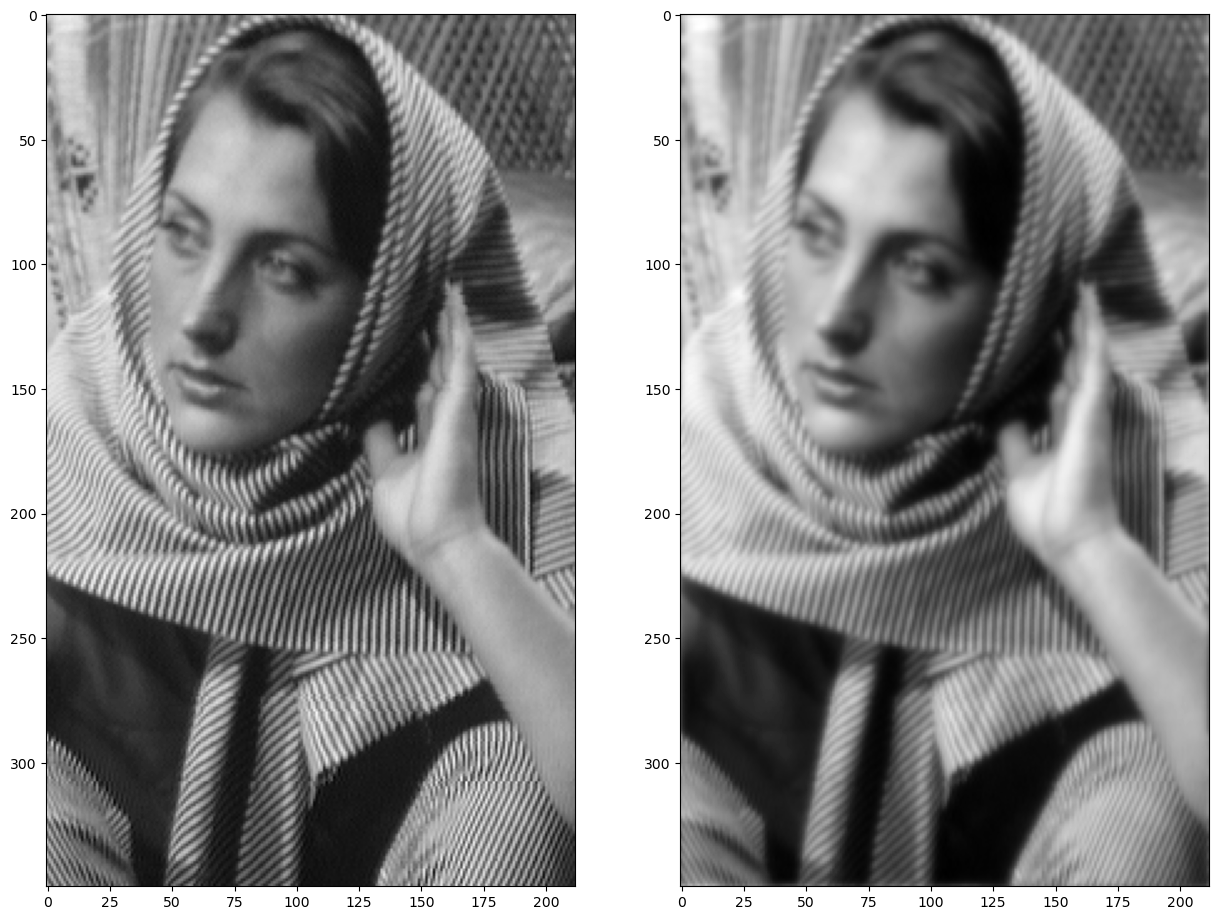

In [7]:
v=u
Lambda=1
out = quadratique_approx(v,Lambda,100)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out,cmap='gray')

## Exercice 1

### 1)

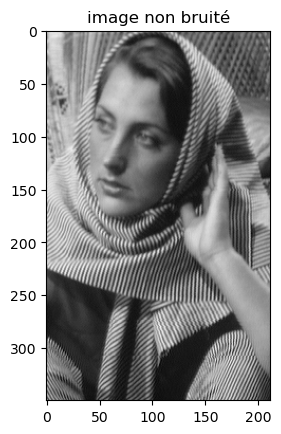

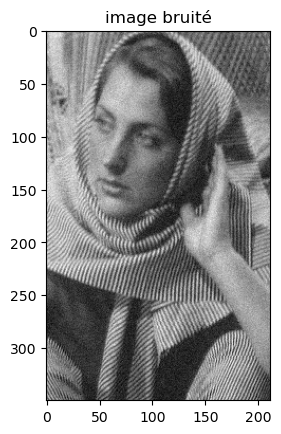

In [8]:
M = np.random.normal(0,10,u.shape) #Matrice de taile de l'image Gaussienne de loi (0,10)
u_bruit = u + M

plt.title('image non bruité')
plt.imshow(u,cmap='gray')
plt.show()
plt.title('image bruité')
plt.imshow(u_bruit,cmap='gray')
plt.show()

### 2) Le code est :

In [9]:
def quadratique_exacte(v,Lambda):

    fftV = np.fft.fft2(v) #Transformé de Fourier de v
    fftOut = np.copy(fftV) #Copie
   
    sx , sy = np.shape(v)  #Taille de la matrice v
    for x in range(sx):
        for y in range(sy):
            fftOut[x][y]= Lambda * fftV[x][y]/(Lambda + 4 - 2*(math.cos(2*math.pi*x/sx)+math.cos(2*math.pi*y/sy)))
    
    out =  np.fft.ifft2(fftOut) #Transformé de Fourier inverse
    out = out.real  #Prendre la partie reel pour avoir une image affichable
    

    return out

C'est un algorithme utilisant la transformée de Fourier qui retourne l’image $w$ minimisant la fonction :$$E(w)=\sum_{i,j=0}^{N-1} |\nabla w_{i,j}|^2 + \lambda \sum_{i,j=0}^{N-1}
(w_{i,j}-v_{i,j})^2,
$$

### 3)

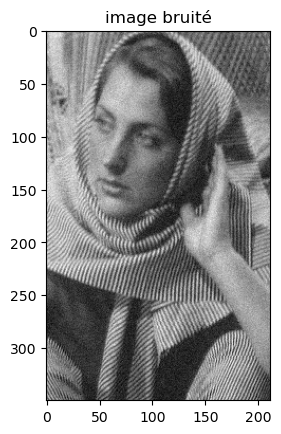

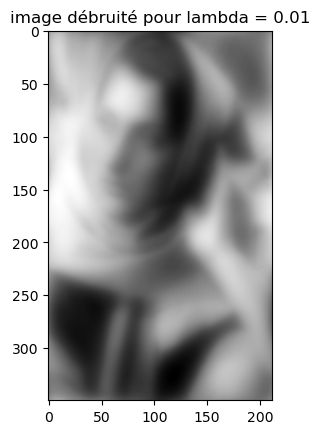

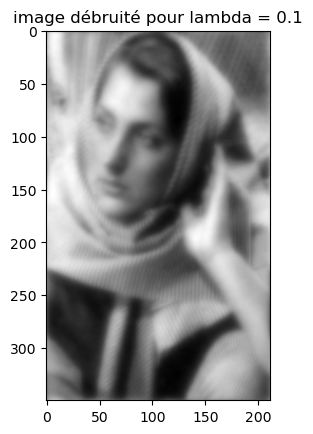

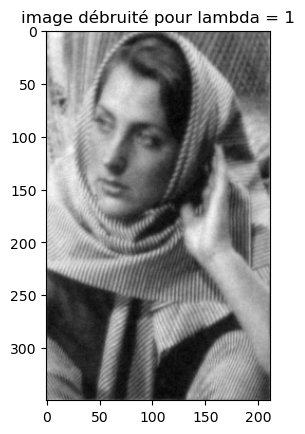

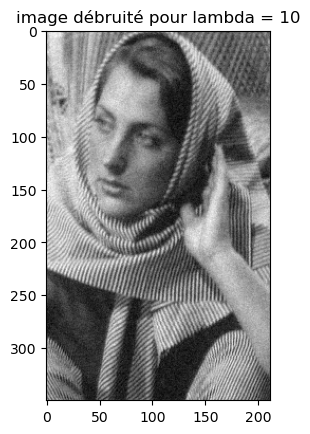

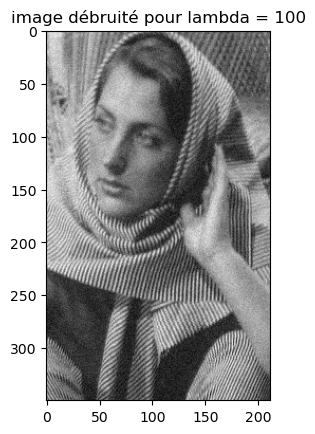

In [10]:
plt.title('image bruité')
plt.imshow(u_bruit,cmap='gray')
plt.show()

for Lambda in [0.01,0.1,1,10,100]:
    
    u_debruit = quadratique_exacte(u_bruit,Lambda)

    plt.title(f'image débruité pour lambda = {Lambda}')
    plt.imshow(u_debruit,cmap='gray')
    plt.show()

Nous préconisons un Lambda = 10 car le Lambda = 100 ressemble à l'image bruité

### 4) Le code est :

In [11]:
def quadratique_approx(v,Lambda,nbIter):
    pas = 0.05
    out_exacte = quadratique_exacte(v,Lambda)
    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)
#    out = out_exacte               # initialisation proche sur la solution (pour tester)
    
    for it in range(nbIter):
        d = grad_E(out,v,Lambda)
        out = out - pas * d
        print( 'iter = ', it , 'fonction = ' , E(out,v,Lambda), 'norm grad =',\
               np.linalg.norm(d), 'distance a la solution = ', np.linalg.norm(out-out_exacte)  )
        
    return out

On utilise quadratique_exacte(v,Lambda) déjà expliqué ci-dessus
on utilise grad_E(out,v,Lambda) qui utilise 

La fonction grad_x(img, adjoint) correspond à l'opérateur Dx de l'exercice appliqué à l'image img si Adjoint = 0, et correspond à l'adjoint Dx$^{\star}$ si Adjoint = 1.
De même pour grad_y(img, adjoint) mais pour Dy.

Ainsi, on sait que $\nabla E(w) = 2Bw + c $ avec B calculé dans le TD et $c = -2\lambda v $

Ceci correspond à grad = 2 * (tmpx1 + tmpy1 + Lambda * (out-v))  dans le code de  grad_E(out,v,Lambda)

avec out = w, tmpx = Dx$^{\star}$(Dx(out)) et tmpy = Dy$^{\star}$(Dy(out)) 


Donc grad_E return bien le gradient de E

out = out - pas * d: On fait une descente de gradiant.

On affiche le numéro de l'itération (it), la valeur de la fonction d'énergie (E(out, v, Lambda)), la norme du gradient (np.linalg.norm(d)), et la distance à la solution exacte (np.linalg.norm(out - out_exacte)).

Enfin, la fonction renvoie la solution mise à jour out.

### 5)

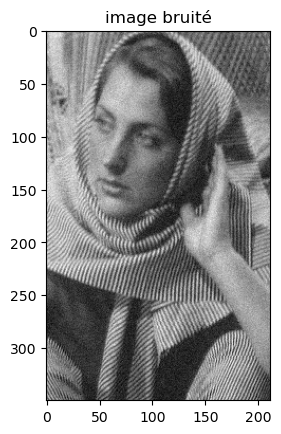

iter =  0 fonction =  703.5025196470564 norm grad = 39323.49307966027 distance a la solution =  8134.076348891922
iter =  1 fonction =  394.486609335558 norm grad = 23502.174441861276 distance a la solution =  7571.298274868956
iter =  2 fonction =  250.5460420261486 norm grad = 15823.950532641124 distance a la solution =  7233.037136009772
iter =  3 fonction =  175.8172461250861 norm grad = 11301.60273541384 distance a la solution =  7009.885513220243
iter =  4 fonction =  133.9791912133256 norm grad = 8396.019029794414 distance a la solution =  6850.25957282527
iter =  5 fonction =  109.01987893112813 norm grad = 6442.713161827416 distance a la solution =  6727.706355062347
iter =  6 fonction =  93.23431715319246 norm grad = 5091.694846871972 distance a la solution =  6627.9293590001635
iter =  7 fonction =  82.68081204043823 norm grad = 4138.036337332267 distance a la solution =  6542.867497009203
iter =  8 fonction =  75.24382491995621 norm grad = 3453.6800461805924 distance a la s

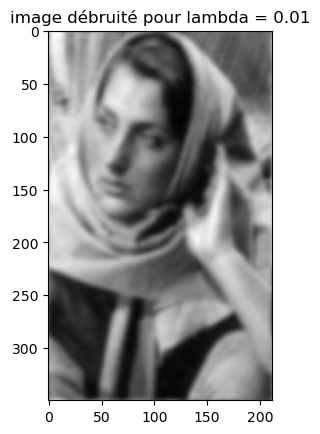

iter =  0 fonction =  708.1915472656125 norm grad = 39323.49307966027 distance a la solution =  5177.367008243422
iter =  1 fonction =  409.452988928098 norm grad = 23163.5191695586 distance a la solution =  4341.756524515492
iter =  2 fonction =  273.5459685555577 norm grad = 15412.015787860497 distance a la solution =  3818.6783747579248
iter =  3 fonction =  204.5454424029407 norm grad = 10884.714510014926 distance a la solution =  3468.8595347954765
iter =  4 fonction =  166.7281740522882 norm grad = 8000.172334936541 distance a la solution =  3220.4736594334026
iter =  5 fonction =  144.61959587841082 norm grad = 6076.680473154317 distance a la solution =  3033.7157402847206
iter =  6 fonction =  130.90276966133376 norm grad = 4756.17935981585 distance a la solution =  2885.782577746166
iter =  7 fonction =  121.89777190330004 norm grad = 3830.0605765753944 distance a la solution =  2763.2822847205684
iter =  8 fonction =  115.66133866045082 norm grad = 3168.8138468398197 distance

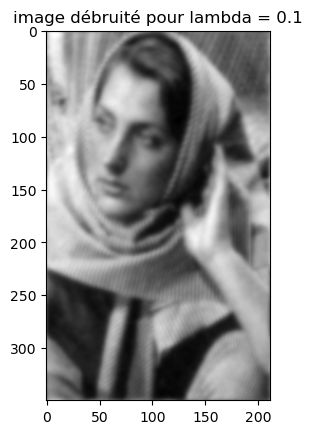

iter =  0 fonction =  755.0818234511745 norm grad = 39323.49307966027 distance a la solution =  2671.5493454631833
iter =  1 fonction =  547.0062132439938 norm grad = 19806.328589089342 distance a la solution =  1760.7049400415174
iter =  2 fonction =  473.2843607829785 norm grad = 11624.516670959747 distance a la solution =  1227.976694053723
iter =  3 fonction =  443.72184639209866 norm grad = 7292.173757129655 distance a la solution =  897.1733124597274
iter =  4 fonction =  430.7641631760629 norm grad = 4789.351846182163 distance a la solution =  681.9282147758369
iter =  5 fonction =  424.6289111583608 norm grad = 3270.9758468717528 distance a la solution =  535.5629993394388
iter =  6 fonction =  421.50768624328225 norm grad = 2316.262808009116 distance a la solution =  431.6723043821806
iter =  7 fonction =  419.80883207937313 norm grad = 1697.15020227038 distance a la solution =  354.9103009956219
iter =  8 fonction =  418.8250216830544 norm grad = 1283.4221349781708 distance a

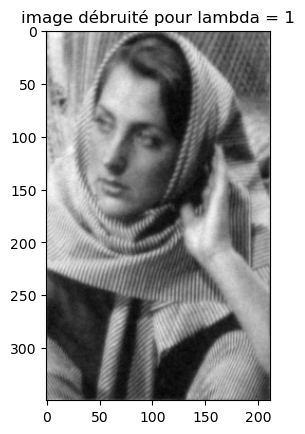

iter =  0 fonction =  1223.9845853067945 norm grad = 39323.49307966027 distance a la solution =  591.4759175481458
iter =  1 fonction =  1175.2308159552113 norm grad = 18096.887411907966 distance a la solution =  323.91448399492793
iter =  2 fonction =  1161.9486017016861 norm grad = 10542.536380069765 distance a la solution =  206.45268304390055
iter =  3 fonction =  1156.938293329156 norm grad = 6943.6188733993795 distance a la solution =  141.79143693291113
iter =  4 fonction =  1154.6897047183134 norm grad = 4850.916355964224 distance a la solution =  101.16202435279487
iter =  5 fonction =  1153.5836383768872 norm grad = 3495.131988046602 distance a la solution =  73.77770017411136
iter =  6 fonction =  1153.0099296715944 norm grad = 2565.354687677075 distance a la solution =  54.583056628100245
iter =  7 fonction =  1152.7019692127294 norm grad = 1906.600336744584 distance a la solution =  40.79839104083512
iter =  8 fonction =  1152.5325996163115 norm grad = 1430.0391501026559 d

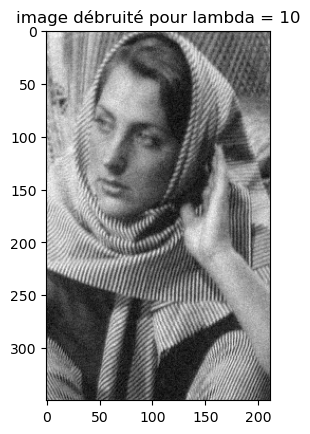

iter =  0 fonction =  5913.012203862995 norm grad = 39323.49307966027 distance a la solution =  1777.5554732005114
iter =  1 fonction =  396476.2333011202 norm grad = 370753.55760095245 distance a la solution =  16760.391289538795
iter =  2 fonction =  35188018.91508255 norm grad = 3497929.6239087237 distance a la solution =  158138.6643461189
iter =  3 fonction =  3138705868.518231 norm grad = 33024302.148217805 distance a la solution =  1493101.0756194456
iter =  4 fonction =  280368934347.51404 norm grad = 312001771.82258874 distance a la solution =  14107223.030735172
iter =  5 fonction =  25079669906891.164 norm grad = 2949747926.92951 distance a la solution =  133382423.35045035
iter =  6 fonction =  2246632745111461.0 norm grad = 27907463615.508293 distance a la solution =  1262012235.7131593
iter =  7 fonction =  2.015420411687166e+17 norm grad = 264220302258.32004 distance a la solution =  11949207725.17377
iter =  8 fonction =  1.8106166097526768e+19 norm grad = 2503367553432

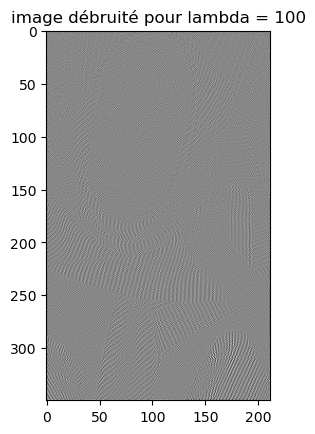

In [12]:
plt.title('image bruité')
plt.imshow(u_bruit,cmap='gray')
plt.show()
nbIter = 25
for Lambda in [0.01,0.1,1,10,100]:
    
    u_debruit = quadratique_approx(u_bruit,Lambda,nbIter)

    plt.title(f'image débruité pour lambda = {Lambda}')
    plt.imshow(u_debruit,cmap='gray')
    plt.show()

Pour $\lambda = 100$, l'algorithme diverge. Il faut changer le pas pour avoir un resultat qui converge : changeons le pas pour pas = 0.01

iter =  0 fonction =  1503.9972212726805 norm grad = 39323.49307966027 distance a la solution =  149.33043501887943
iter =  1 fonction =  1492.3033502383776 norm grad = 31123.485905370253 distance a la solution =  118.21221470454505
iter =  2 fonction =  1484.9772864370457 norm grad = 24634.333275228946 distance a la solution =  93.58203092353611
iter =  3 fonction =  1480.3872536549063 norm grad = 19498.883986675908 distance a la solution =  74.08641680659143
iter =  4 fonction =  1477.5112235649524 norm grad = 15434.586107640502 distance a la solution =  58.65440733681989
iter =  5 fonction =  1475.7090215838655 norm grad = 12217.896351882671 distance a la solution =  46.43854130435595
iter =  6 fonction =  1474.579626873444 norm grad = 9671.94963535973 distance a la solution =  36.76819146204341
iter =  7 fonction =  1473.8718112670306 norm grad = 7656.806676466475 distance a la solution =  29.11264531243276
iter =  8 fonction =  1473.4281755905804 norm grad = 6061.74031204276 dista

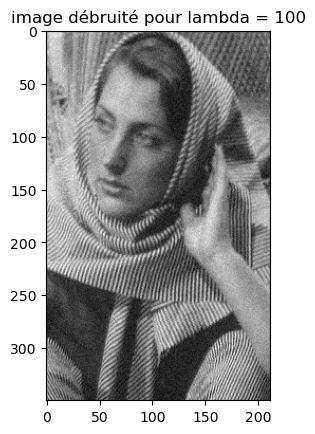

In [13]:
def quadratique_approx(v,Lambda,nbIter):
    pas = 0.001
    out_exacte = quadratique_exacte(v,Lambda)
    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)
#    out = out_exacte               # initialisation proche sur la solution (pour tester)
    
    for it in range(nbIter):
        d = grad_E(out,v,Lambda)
        out = out - pas * d
        print( 'iter = ', it , 'fonction = ' , E(out,v,Lambda), 'norm grad =',\
               np.linalg.norm(d), 'distance a la solution = ', np.linalg.norm(out-out_exacte)  )
        
    return out

u_debruit = quadratique_approx(u_bruit,100,nbIter)

plt.title(f'image débruité pour lambda = {100}')
plt.imshow(u_debruit,cmap='gray')
plt.show()

### 6)

In [14]:
def pasopti(d,Lambda):
    tmpx = grad_x(d,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(d,0)
    tmpy1 = grad_y(tmpy,1)
    
    B_d =  tmpx1 + tmpy1 + Lambda * d 
    
    return np.sum(np.multiply(d,d))/(2*np.sum(np.multiply(B_d,d)))


def quadratique_approx1(v, Lambda, nbIter):
    out_exacte = quadratique_exacte(v, Lambda)
    out = np.copy(v)                
    
    for it in range(nbIter):
        d = grad_E(out, v, Lambda)
        
        pas = pasopti(d,Lambda)
        out = out - pas * d
        print('iter =', it, 'fonction =', E(out, v, Lambda), 'norm grad =',
              np.linalg.norm(d), 'distance a la solution =', np.linalg.norm(out - out_exacte), 'pas =', pas)
        
    return out


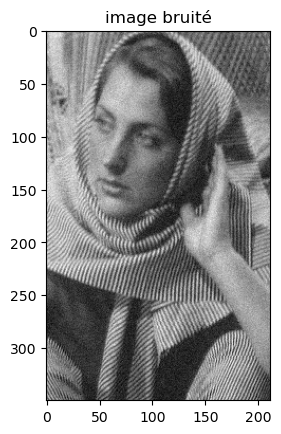

iter = 0 fonction = 329.677623066514 norm grad = 39323.49307966027 distance a la solution = 3953.428684118376 pas = 0.11448941963924493
iter = 1 fonction = 173.85773709035774 norm grad = 15517.061857348112 distance a la solution = 3284.034819694716 pas = 0.09603682645678724
iter = 2 fonction = 131.58323122696774 norm grad = 7358.284202340163 distance a la solution = 2888.9407370140884 pas = 0.11586688337691295
iter = 3 fonction = 115.36116938666868 norm grad = 4847.877821451141 distance a la solution = 2660.651101466368 pas = 0.10243222857778078
iter = 4 fonction = 106.96285752269007 norm grad = 3146.1216164363527 distance a la solution = 2445.764744072115 pas = 0.12591425067468492
iter = 5 fonction = 101.7754148234733 norm grad = 2672.4133213274736 distance a la solution = 2293.409776228643 pas = 0.10779036873155866
iter = 6 fonction = 98.14970077012836 norm grad = 2033.1378087051503 distance a la solution = 2134.960047441388 pas = 0.1301648785527225
iter = 7 fonction = 95.46337664622

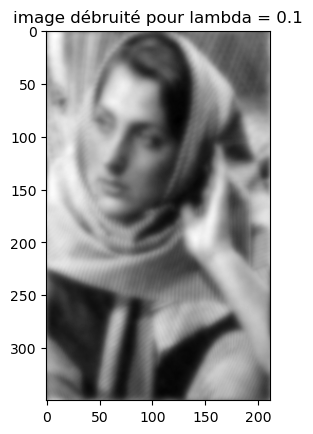

iter = 0 fonction = 533.521199341034 norm grad = 39323.49307966027 distance a la solution = 1568.9735041243935 pas = 0.09492681161353694
iter = 1 fonction = 442.18951660328867 norm grad = 12865.688483437563 distance a la solution = 859.4082668033243 pas = 0.08188216122358265
iter = 2 fonction = 424.7087587296213 norm grad = 5201.775378687812 distance a la solution = 518.8547599446437 pas = 0.09587181933820652
iter = 3 fonction = 420.02246962003534 norm grad = 2835.6873548482117 distance a la solution = 360.96074219375714 pas = 0.08648609446340565
iter = 4 fonction = 418.35251156257635 norm grad = 1553.788315947119 distance a la solution = 249.47699991483293 pas = 0.10264924556657762
iter = 5 fonction = 417.6482480562018 norm grad = 1075.9717008901591 distance a la solution = 184.9208136948393 pas = 0.09027497719015164
iter = 6 fonction = 417.3142505260223 norm grad = 685.5694675344487 distance a la solution = 132.98545810415763 pas = 0.1054567106669603
iter = 7 fonction = 417.146753696

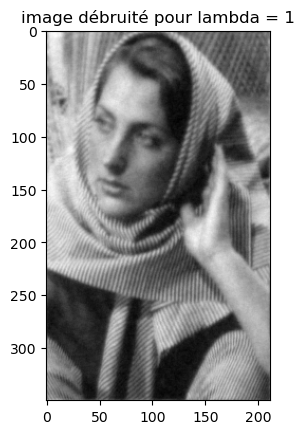

In [15]:
plt.title('image bruité')
plt.imshow(u_bruit,cmap='gray')
plt.show()
nbIter = 25
for Lambda in [0.1,1]:
    
    u_debruit = quadratique_approx1(u_bruit,Lambda,nbIter)

    plt.title(f'image débruité pour lambda = {Lambda}')
    plt.imshow(u_debruit,cmap='gray')
    plt.show()

### 7)

Lors de l'application de la règle d'Armijo , on souhaite généralement utiliser une mesure de l'erreur qui ne dépend pas du nombre d'éléments de la matrice, car la règle d'Armijo est généralement appliquée à des problèmes d'optimisation de manière globale et non élément par élément.

Donc, on doit modifier la fonction E sans normalisation par élément pour assurer que la comparaison entre les valeurs de la fonction est cohérente et ne dépend pas de la taille de la matrice:

In [16]:
def E(out,v,Lambda):
    sx , sy = np.shape(out)
    gx = np.linalg.norm( grad_x(out,0), ord='fro')
    gy = np.linalg.norm( grad_y(out,0), ord='fro')
    data = np.linalg.norm( out - v , ord='fro')
    
    return gx*gx + gy*gy + Lambda *data*data

In [17]:
# on définit la règle d'Armijo

def armijo_rule(alpha_0,x,f,grad,d_x,c,beta,v, Lambda): #d_x est la direction de descente d_x . grad_x <= 0
    test = 1
    alpha = alpha_0 #Initialisation du pas
    
    while test: #Tant que test == 1
        
        x_new = x+alpha*d_x #On calcul l'itéré suivant pour tester si alpha est acceptable selon Armijo :
        
        if f(x,v, Lambda)-f(x_new,v, Lambda) >= c*alpha*np.linalg.norm(grad(x,v, Lambda),'fro')**2 :
        #if f(x_new,v, Lambda)<=f(x,v, Lambda)+c*alpha*np.linalg.norm( np.dot(np.transpose(grad(x,v, Lambda)),d_x), 'fro'): #On prend la norme de Frob
            
            #On sors du while
            test = 0
            
        else:
            #Sinon on reduit le pas alpha en multipliant par un certain beta definit arbitrairement dans ]0,1[
            alpha = alpha*beta
            #print(alpha)
            #On continue dans la boucle while car test = 1
            
    return alpha 


In [18]:
#Initialisation
c = 0.5

def quadratique_approx2(v, Lambda, nbIter, alpha=0.9, beta=0.5):
    #Sol exact pour comparer
    out_exacte = quadratique_exacte(v, Lambda) 
    
    #Copie de l'image pour eviter de la modifier
    out = np.copy(v)                
    
    for it in range(nbIter):
        #Direction de descente
        d = -grad_E(out, v, Lambda)
        
        #Calcul du pas selon Armijo
        pas = armijo_rule(alpha,out,E,grad_E,d,c,beta,v, Lambda)
        
        #Initalisation de la nouvelle itéré
        out = out + pas * d
        
        print('iter =', it, 'fonction =', E(out, v, Lambda), 'norm grad =',
              np.linalg.norm(d), 'distance a la solution =', np.linalg.norm(out - out_exacte), 'pas =', pas)
        
    return out

### 8)

Test pour $\lambda = 0.1$ et $\lambda = 1$ :

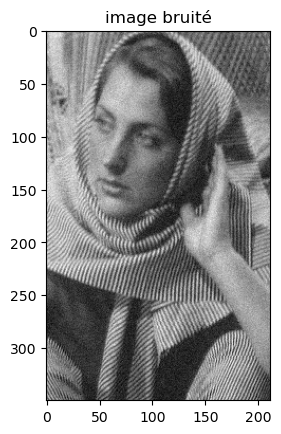

iter = 0 fonction = 24488807.33413282 norm grad = 39323.49307966027 distance a la solution = 3972.6666376744192 pas = 0.1125
iter = 1 fonction = 15107896.652343934 norm grad = 15262.733594326792 distance a la solution = 3517.786341336073 pas = 0.05625
iter = 2 fonction = 10202048.855763733 norm grad = 7855.184440135741 distance a la solution = 3014.71534297793 pas = 0.1125
iter = 3 fonction = 8142685.2329904735 norm grad = 4180.46293538839 distance a la solution = 2500.8004666620227 pas = 0.225
iter = 4 fonction = 7720718.638552373 norm grad = 3255.6979943491465 distance a la solution = 2412.6929013821264 pas = 0.05625
iter = 5 fonction = 7221896.300958263 norm grad = 1756.0730759557077 distance a la solution = 2119.2355751239925 pas = 0.225
iter = 6 fonction = 7032522.709966047 norm grad = 1654.9328467684745 distance a la solution = 2001.816709553297 pas = 0.1125
iter = 7 fonction = 6895275.538811376 norm grad = 1276.2186571584364 distance a la solution = 1895.9297623618347 pas = 0.11

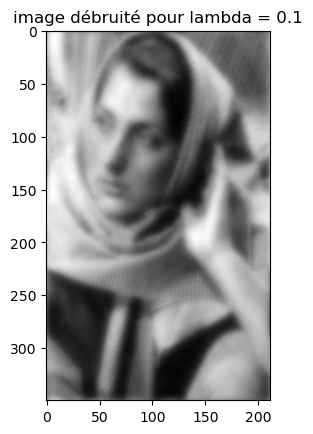

iter = 0 fonction = 51771181.19772288 norm grad = 39323.49307966027 distance a la solution = 2472.437486723411 pas = 0.05625
iter = 1 fonction = 32629829.96059678 norm grad = 17743.22765962363 distance a la solution = 849.9816259680049 pas = 0.1125
iter = 2 fonction = 31343765.02381262 norm grad = 4527.429812326363 distance a la solution = 469.6316825356586 pas = 0.1125
iter = 3 fonction = 31089215.251201183 norm grad = 2055.0055838326393 distance a la solution = 302.31313254572746 pas = 0.1125
iter = 4 fonction = 31026060.09871766 norm grad = 1223.7737658781346 distance a la solution = 249.20108429272142 pas = 0.05625
iter = 5 fonction = 30953440.178526096 norm grad = 736.8488736195103 distance a la solution = 101.51350675053854 pas = 0.225
iter = 6 fonction = 30947100.80900655 norm grad = 392.6492606640579 distance a la solution = 85.5077644222037 pas = 0.05625
iter = 7 fonction = 30940330.85380411 norm grad = 222.41531970648606 distance a la solution = 39.95550269761088 pas = 0.225


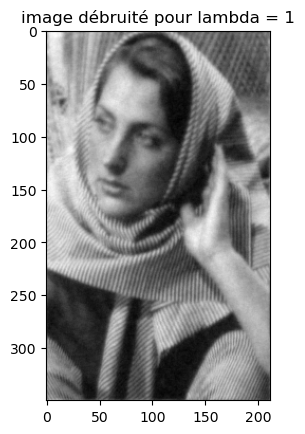

In [19]:
plt.title('image bruité')
plt.imshow(u_bruit,cmap='gray')
plt.show()
nbIter = 25
for Lambda in [0.1,1]:
    
    u_debruit = quadratique_approx2(u_bruit,Lambda,nbIter)

    plt.title(f'image débruité pour lambda = {Lambda}')
    plt.imshow(u_debruit,cmap='gray')
    plt.show()

Pas Fixe : Simple à implémenter mais peut nécessiter un réglage minutieux pour choisir une bonne valeur de pas. Elle peut également être moins efficace dans des problèmes où la fonction objectif présente une variabilité importante.

Pas Optimal : Approche plus sophistiquée mais qui peut être coûteuse en termes de calculs. Elle peut être très efficace mais peut également être sujette à des problèmes numériques si elle n'est pas stabilisée correctement.

Règle d'Armijo : Compromis entre la simplicité de la stratégie de pas fixe et l'efficacité de la recherche du pas optimal. 

## Exercice 2

### 1)

In [20]:
def pastk(w,d,v,Lambda):
    tmpx = grad_x(d,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(d,0)
    tmpy1 = grad_y(tmpy,1)
    
    B_d =  tmpx1 + tmpy1 + Lambda * d 
    
    return np.sum(np.multiply(grad_E(w, v, Lambda),d))/(2*np.sum(np.multiply(B_d,d)))

In [21]:
def quadratique_approx3(v, Lambda, nbIter,tolerance):
    #Sol exact pour comparer
    out_exacte = quadratique_exacte(v, Lambda) 
    
    #Copie de l'image pour eviter de la modifier (Initialisation de w0)
    out = np.copy(v) 
    
    # Initialisation du gradient précédent à zéro
    prev_grad = grad_E(out, v, Lambda)
    
    # Initialisation de la direction de recherche d0
    d = grad_E(out, v, Lambda)
    
    # Initialisation de w1
    w = out - pasopti(d,Lambda)*d
    
    
    # Boucle principale pour les itérations
    it = 0
    while True:
        # Calcul de la direction de recherche
        d = grad_E(w, v, Lambda) + (np.linalg.norm(grad_E(w, v, Lambda),'fro')**2 / np.linalg.norm(prev_grad,'fro')**2) * d
             
        # Calcul du pas
        tk = pastk(w,d,v,Lambda)
        
        # Mise à jour pour la prochaine itération
        prev_grad = grad_E(w, v, Lambda)
        
        # Mise à jour de l'image
        w = w - tk * d
        
        
        # Vérification de la convergence
        if np.linalg.norm(prev_grad) < tolerance or it >= nbIter:
            break
        
        it += 1
        
        # Affichage des détails de l'itération
        print('iter =', it, 'fonction =', E(w, v, Lambda), 'norm grad =',
              np.linalg.norm(prev_grad), 'distance a la solution =', np.linalg.norm(w - out_exacte), 'pas =', tk)
        
    return w


### 2)

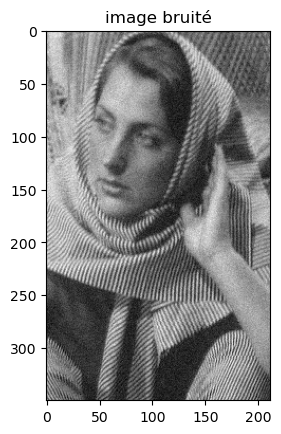

iter = 1 fonction = 8408044.021205634 norm grad = 15843.567612319035 distance a la solution = 6776.3782164086315 pas = 0.11307072966845773
iter = 2 fonction = 5516611.293640777 norm grad = 6334.287394088069 distance a la solution = 6474.044810849665 pas = 0.14412773451892166
iter = 3 fonction = 4354584.871454343 norm grad = 3592.5108330642997 distance a la solution = 6172.437622277221 pas = 0.18007350837542696
iter = 4 fonction = 3451721.912805712 norm grad = 2829.533919880497 distance a la solution = 5779.859230429761 pas = 0.22553919311442552
iter = 5 fonction = 2910712.9798163874 norm grad = 2393.679975417745 distance a la solution = 5454.307163226111 pas = 0.18884359455216684
iter = 6 fonction = 2543805.994525335 norm grad = 1827.3534552984902 distance a la solution = 5136.373594489007 pas = 0.21975605908287577
iter = 7 fonction = 2234377.7126748096 norm grad = 1657.8212953683178 distance a la solution = 4793.184751170194 pas = 0.2251720975677235
iter = 8 fonction = 2024377.9002737

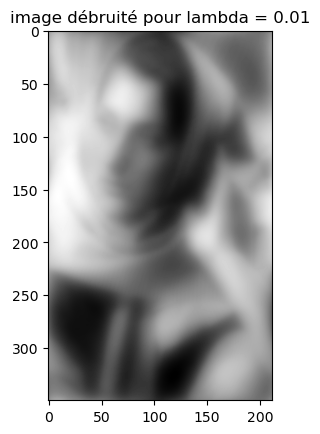

iter = 1 fonction = 11163239.269749379 norm grad = 15517.061857348112 distance a la solution = 3103.682386860593 pas = 0.11046502257756843
iter = 2 fonction = 8594801.638009904 norm grad = 6060.784812347182 distance a la solution = 2669.4990710001384 pas = 0.1398431798466441
iter = 3 fonction = 7635808.907890719 norm grad = 3335.2079523947004 distance a la solution = 2283.128408483734 pas = 0.1724246985114792
iter = 4 fonction = 6971257.808407126 norm grad = 2515.2976498964604 distance a la solution = 1837.3637216172026 pas = 0.21007753189657466
iter = 5 fonction = 6626247.8746094555 norm grad = 1981.9749047130524 distance a la solution = 1516.592032441044 pas = 0.17565693192194984
iter = 6 fonction = 6426007.633750329 norm grad = 1407.40036027343 distance a la solution = 1240.9043748599793 pas = 0.20218365296832708
iter = 7 fonction = 6285780.004813721 norm grad = 1174.7298215396509 distance a la solution = 986.5096377246351 pas = 0.2032298977921118
iter = 8 fonction = 6207902.0954886

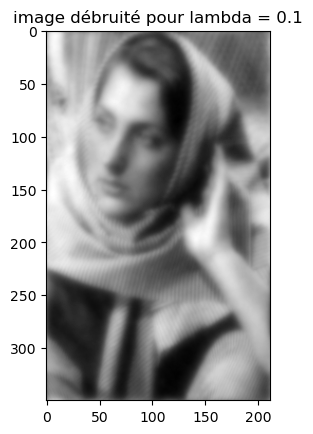

iter = 1 fonction = 32121077.41666498 norm grad = 12865.688483437563 distance a la solution = 705.5371697609937 pas = 0.09021178876911926
iter = 2 fonction = 31206181.883413963 norm grad = 4103.844662165854 distance a la solution = 383.2697662480378 pas = 0.10864748453164567
iter = 3 fonction = 31015749.559262156 norm grad = 1754.5403146930278 distance a la solution = 209.45184188183623 pas = 0.12372115345667935
iter = 4 fonction = 30955586.84819894 norm grad = 949.4548209513807 distance a la solution = 97.0974576702633 pas = 0.13347772193165455
iter = 5 fonction = 30942404.766322978 norm grad = 475.34863342349706 distance a la solution = 50.36317781967614 pas = 0.11667814101038826
iter = 6 fonction = 30939144.62259999 norm grad = 224.21050889190155 distance a la solution = 25.42711880574024 pas = 0.1297044311008435
iter = 7 fonction = 30938238.773322497 norm grad = 120.05633313219478 distance a la solution = 12.137166889337598 pas = 0.1256943593347485
iter = 8 fonction = 30938037.4590

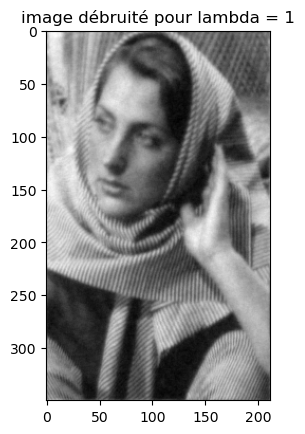

iter = 1 fonction = 85507133.77171738 norm grad = 4749.795505934141 distance a la solution = 20.983554582106404 pas = 0.03356114170698575
iter = 2 fonction = 85501442.80302207 norm grad = 563.6457366804522 distance a la solution = 3.065814342751764 pas = 0.035826446940046254
iter = 3 fonction = 85501326.77525029 norm grad = 79.46259216830848 distance a la solution = 0.48993041548186267 pas = 0.03675077411039323
iter = 4 fonction = 85501323.77124028 norm grad = 12.7730970420997 distance a la solution = 0.06592379603911255 pas = 0.03682467713366284
iter = 5 fonction = 85501323.71551889 norm grad = 1.7642670339714241 distance a la solution = 0.009878057575832409 pas = 0.03580330557677926
iter = 6 fonction = 85501323.71431279 norm grad = 0.2553534077916279 distance a la solution = 0.0014754844331462881 pas = 0.036993873142132996


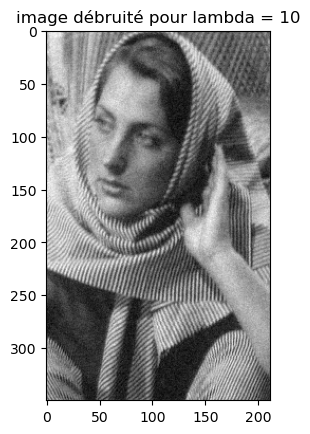

iter = 1 fonction = 109273063.48248002 norm grad = 649.9296723693354 distance a la solution = 0.05253913356367768 pas = 0.0047583765954710335
iter = 2 fonction = 109273063.19541669 norm grad = 10.935024574572221 distance a la solution = 0.0009956114571750877 pas = 0.004801403367469556
iter = 3 fonction = 109273063.19531393 norm grad = 0.2066049480490412 distance a la solution = 2.0956683705922017e-05 pas = 0.004814851443168547


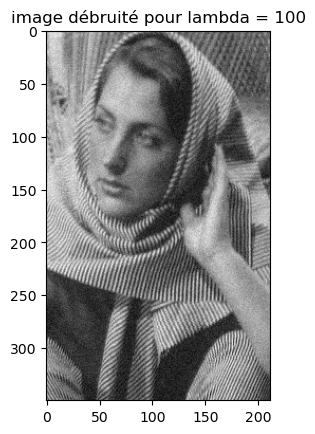

In [22]:
plt.title('image bruité')
plt.imshow(u_bruit,cmap='gray')
plt.show()

nbIter = 50
tolerance = 0.1

for Lambda in [0.01,0.1,1,10,100]:
    
    u_debruit = quadratique_approx3(u_bruit,Lambda,nbIter,tolerance)

    plt.title(f'image débruité pour lambda = {Lambda}')
    plt.imshow(u_debruit,cmap='gray')
    plt.show()

Pour $\epsilon = 0.1$ on a pour : 

$\lambda = 0.01$, on a 300^2 itérations
$\lambda = 0.1$, on a 50 itérations
$\lambda = 1$, on a 50 itérations

# Exercice 3

### 1)

In [40]:
def quadratique_approx4(v, Lambda, nbIter,tolerance):
    #Sol exact pour comparer
    out_exacte = quadratique_exacte(v, Lambda) 
    
    # Calcul de la constante de Lipschitz du gradient
    L = 2*Lambda + 12
    
    # Initialisation du pas
    t = 1/L
    
    #Copie de l'image pour eviter de la modifier (Initialisation de w0)
    w = np.copy(v) 
    
    # Initialisation de v1
    p = np.copy(w)
    
   
    # Boucle principale pour les itérations
    k = 1
    while True:
        
        w_next = p - t*grad_E(p, v, Lambda)
        
        p = w_next - (k-1)/(k+2)*( w_next - w )
         
          
        # Vérification de la convergence
        if np.linalg.norm(grad_E(p, v, Lambda)) < tolerance or k >= nbIter:
            break
        
        k += 1
        
        # Mise à jour pour la prochaine itéré
        w = np.copy(w_next)
        
        # Affichage des détails de l'itération
        print('iter =', k, 'fonction =', E(w, v, Lambda), 'norm grad =',
              np.linalg.norm(grad_E(p, v, Lambda)), 'distance a la solution =', np.linalg.norm(w - out_exacte), 'pas =', k)
        
    return w


### 2)

iter = 2 fonction = 30112641.26859579 norm grad = 15990.025297318065 distance a la solution = 7625.280199685394 pas = 2
iter = 3 fonction = 14099351.489556136 norm grad = 10396.453960409042 distance a la solution = 7089.465883234244 pas = 3
iter = 4 fonction = 9971608.310084267 norm grad = 7282.739821863743 distance a la solution = 6878.853220392709 pas = 4
iter = 5 fonction = 7841591.8642224725 norm grad = 5523.2138207788985 distance a la solution = 6733.934348909463 pas = 5
iter = 6 fonction = 6697687.338349147 norm grad = 4358.872724956202 distance a la solution = 6628.344719025858 pas = 6
iter = 7 fonction = 5961303.861379123 norm grad = 3591.845684498001 distance a la solution = 6541.118133906223 pas = 7
iter = 8 fonction = 5463089.560376338 norm grad = 3050.1910051307377 distance a la solution = 6466.721701347301 pas = 8
iter = 9 fonction = 5094402.677142821 norm grad = 2664.8881789106917 distance a la solution = 6400.228764448394 pas = 9
iter = 10 fonction = 4810462.376488638 no

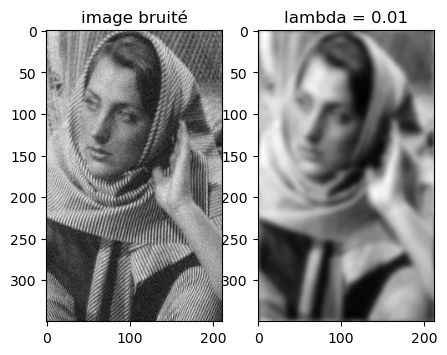

iter = 2 fonction = 31604885.308446735 norm grad = 15754.10689129206 distance a la solution = 4433.713033964292 pas = 2
iter = 3 fonction = 16365856.419628667 norm grad = 10148.182713898732 distance a la solution = 3599.038864066254 pas = 3
iter = 4 fonction = 12548875.276502736 norm grad = 7034.210032311651 distance a la solution = 3270.6874464239736 pas = 4
iter = 5 fonction = 10614626.158233512 norm grad = 5285.688114354942 distance a la solution = 3048.6130834664586 pas = 5
iter = 6 fonction = 9597483.754404644 norm grad = 4132.063910950732 distance a la solution = 2892.5113303662697 pas = 6
iter = 7 fonction = 8954381.666967437 norm grad = 3374.453230160329 distance a la solution = 2767.3560279676076 pas = 7
iter = 8 fonction = 8527462.460481506 norm grad = 2839.82740413225 distance a la solution = 2663.8062722376953 pas = 8
iter = 9 fonction = 8217061.145100536 norm grad = 2459.4173533527182 distance a la solution = 2573.5243591494177 pas = 9
iter = 10 fonction = 7982265.58523608

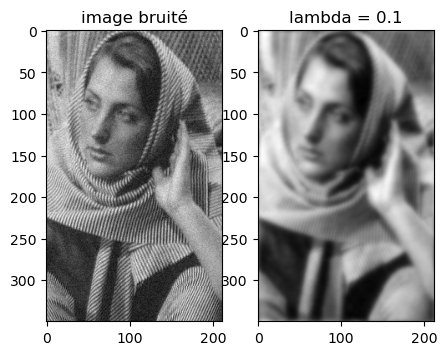

iter = 2 fonction = 44084615.51529948 norm grad = 13728.578862411654 distance a la solution = 2031.8682067037926 pas = 2
iter = 3 fonction = 34431287.06913798 norm grad = 8134.363456596353 distance a la solution = 1154.9479797202077 pas = 3
iter = 4 fonction = 32578346.59885365 norm grad = 5112.28230769748 distance a la solution = 840.4079305043601 pas = 4
iter = 5 fonction = 31781075.33471802 norm grad = 3531.4503104878977 distance a la solution = 639.5007824826614 pas = 5
iter = 6 fonction = 31436161.237633638 norm grad = 2529.076591991304 distance a la solution = 514.7979970157988 pas = 6
iter = 7 fonction = 31251080.065769464 norm grad = 1901.9170721478993 distance a la solution = 424.64195491659444 pas = 7
iter = 8 fonction = 31148012.75704331 norm grad = 1472.6156251555196 distance a la solution = 358.5988621379907 pas = 8
iter = 9 fonction = 31084262.63791144 norm grad = 1176.4997703126373 distance a la solution = 306.7887679575136 pas = 9
iter = 10 fonction = 31043418.53592047 

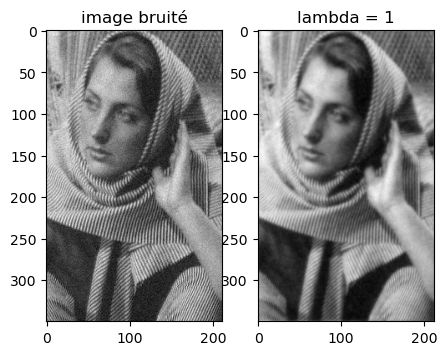

iter = 2 fonction = 86203512.85239926 norm grad = 6006.253252305098 distance a la solution = 234.78488906658225 pas = 2
iter = 3 fonction = 85532783.99188611 norm grad = 2385.9028401515434 distance a la solution = 50.79242420690113 pas = 3
iter = 4 fonction = 85507068.19058475 norm grad = 811.8485336177828 distance a la solution = 21.877281618642776 pas = 4
iter = 5 fonction = 85502137.25297914 norm grad = 360.0142065033088 distance a la solution = 8.337635577529456 pas = 5
iter = 6 fonction = 85501502.44319573 norm grad = 150.71262896939135 distance a la solution = 3.938922163454698 pas = 6
iter = 7 fonction = 85501359.83747754 norm grad = 71.96982648929715 distance a la solution = 1.7889481711000146 pas = 7
iter = 8 fonction = 85501332.79213819 norm grad = 33.69729049801676 distance a la solution = 0.9031029737820784 pas = 8
iter = 9 fonction = 85501325.93322484 norm grad = 17.06258157617476 distance a la solution = 0.4498745850349006 pas = 9
iter = 10 fonction = 85501324.32871792 no

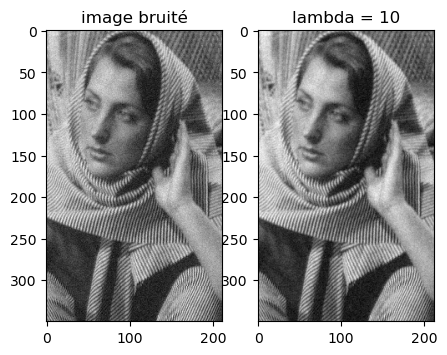

iter = 2 fonction = 109275059.24385391 norm grad = 906.604264498884 distance a la solution = 4.403695010390576 pas = 2
iter = 3 fonction = 109273065.15331113 norm grad = 246.28786462235158 distance a la solution = 0.1383280201406656 pas = 3
iter = 4 fonction = 109273063.34447464 norm grad = 16.010483804587473 distance a la solution = 0.0381888743008966 pas = 4
iter = 5 fonction = 109273063.1961223 norm grad = 4.184981212321404 distance a la solution = 0.0028167903849000584 pas = 5
iter = 6 fonction = 109273063.1953708 norm grad = 0.393238665299112 distance a la solution = 0.0007476552950783501 pas = 6
iter = 7 fonction = 109273063.19531447 norm grad = 0.10092089162962295 distance a la solution = 7.68805527335883e-05 pas = 7


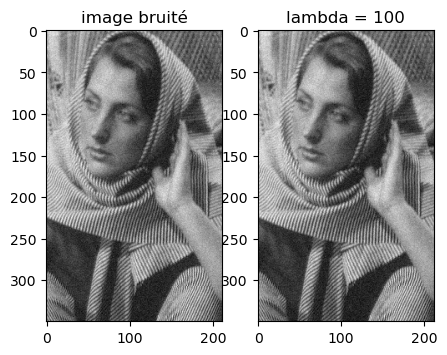

In [47]:
nbIter = 50
tolerance = 0.1

for Lambda in [0.01,0.1,1,10,100]:
    
    u_debruit = quadratique_approx4(u_bruit,Lambda,nbIter,tolerance)
    
    plt.figure(figsize = (5,10))
    
    plt.subplot(1,2,1)
    plt.title('image bruité')
    plt.imshow(u_bruit,cmap='gray')
    
    plt.subplot(1,2,2)
    plt.title(f'lambda = {Lambda}')
    plt.imshow(u_debruit,cmap='gray')
    plt.show()
    
#     plt.title('image bruité')
#     plt.imshow(u_bruit,cmap='gray')
#     plt.show()
    
#     plt.title(f'image débruité pour lambda = {Lambda}')
#     plt.imshow(u_debruit,cmap='gray')
#     plt.show()

## Détail du calcul de la constante de Lipschitz du gradient :

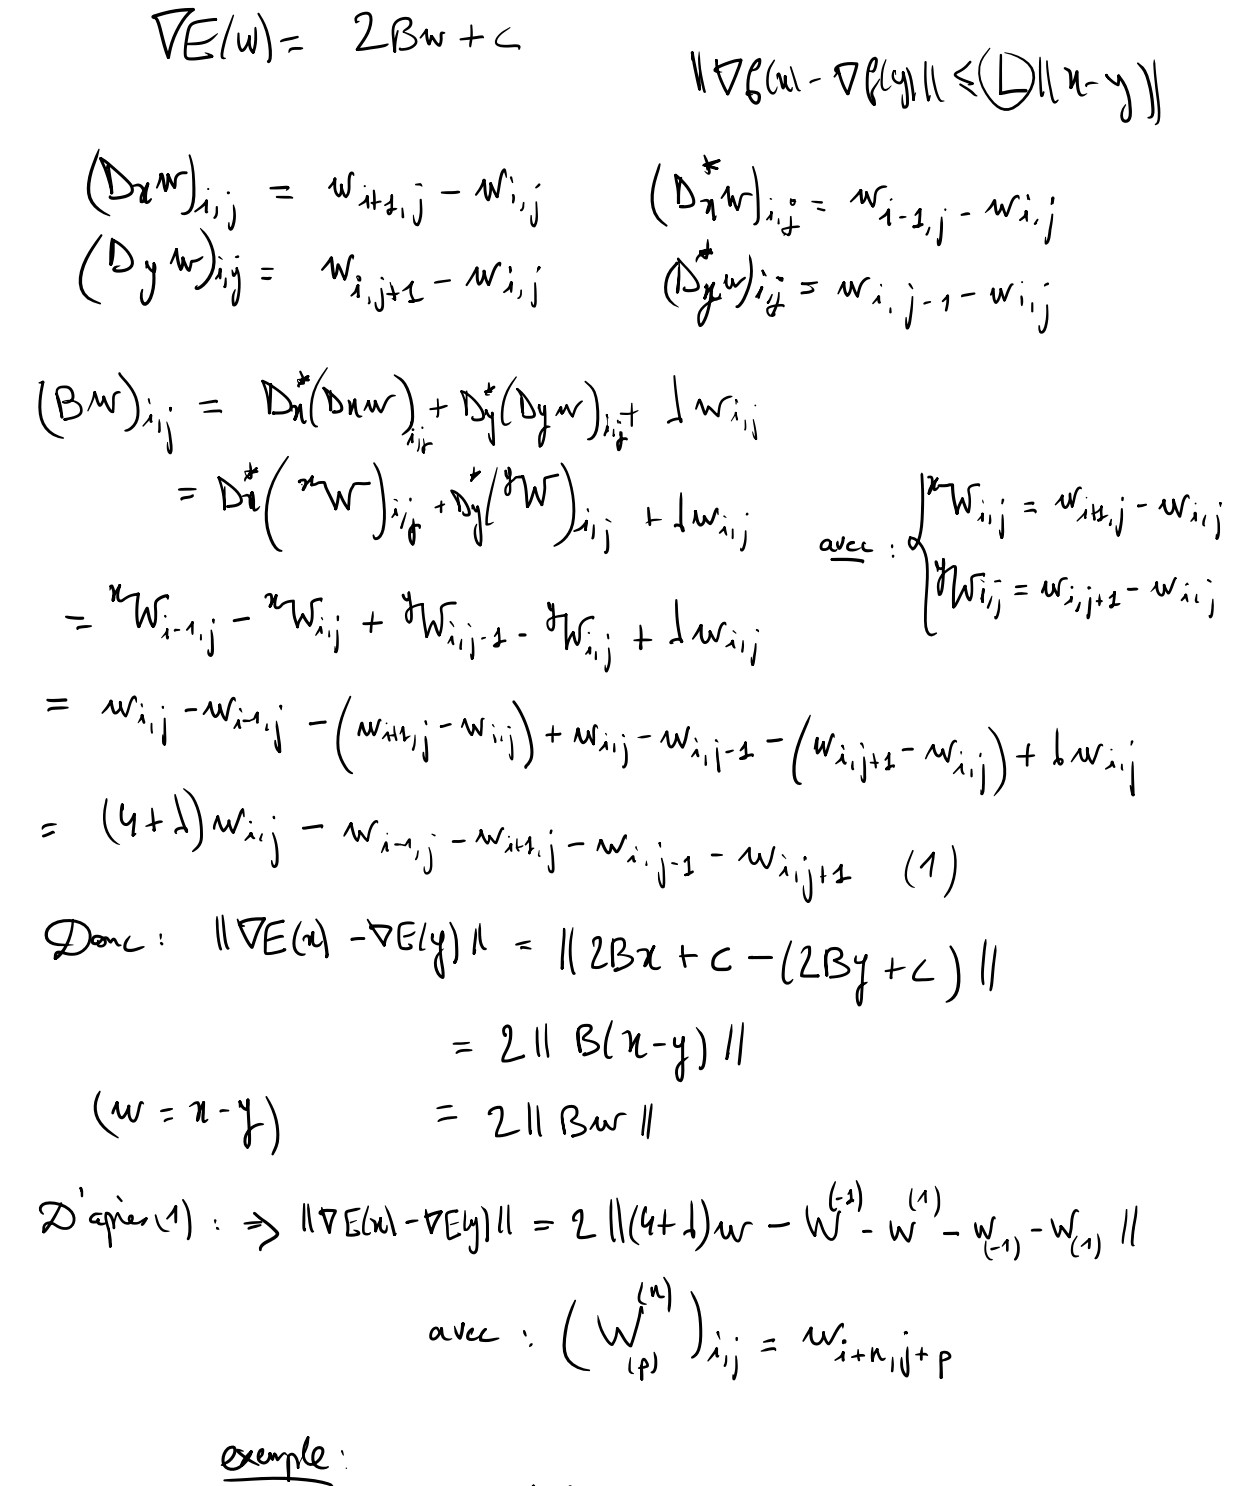

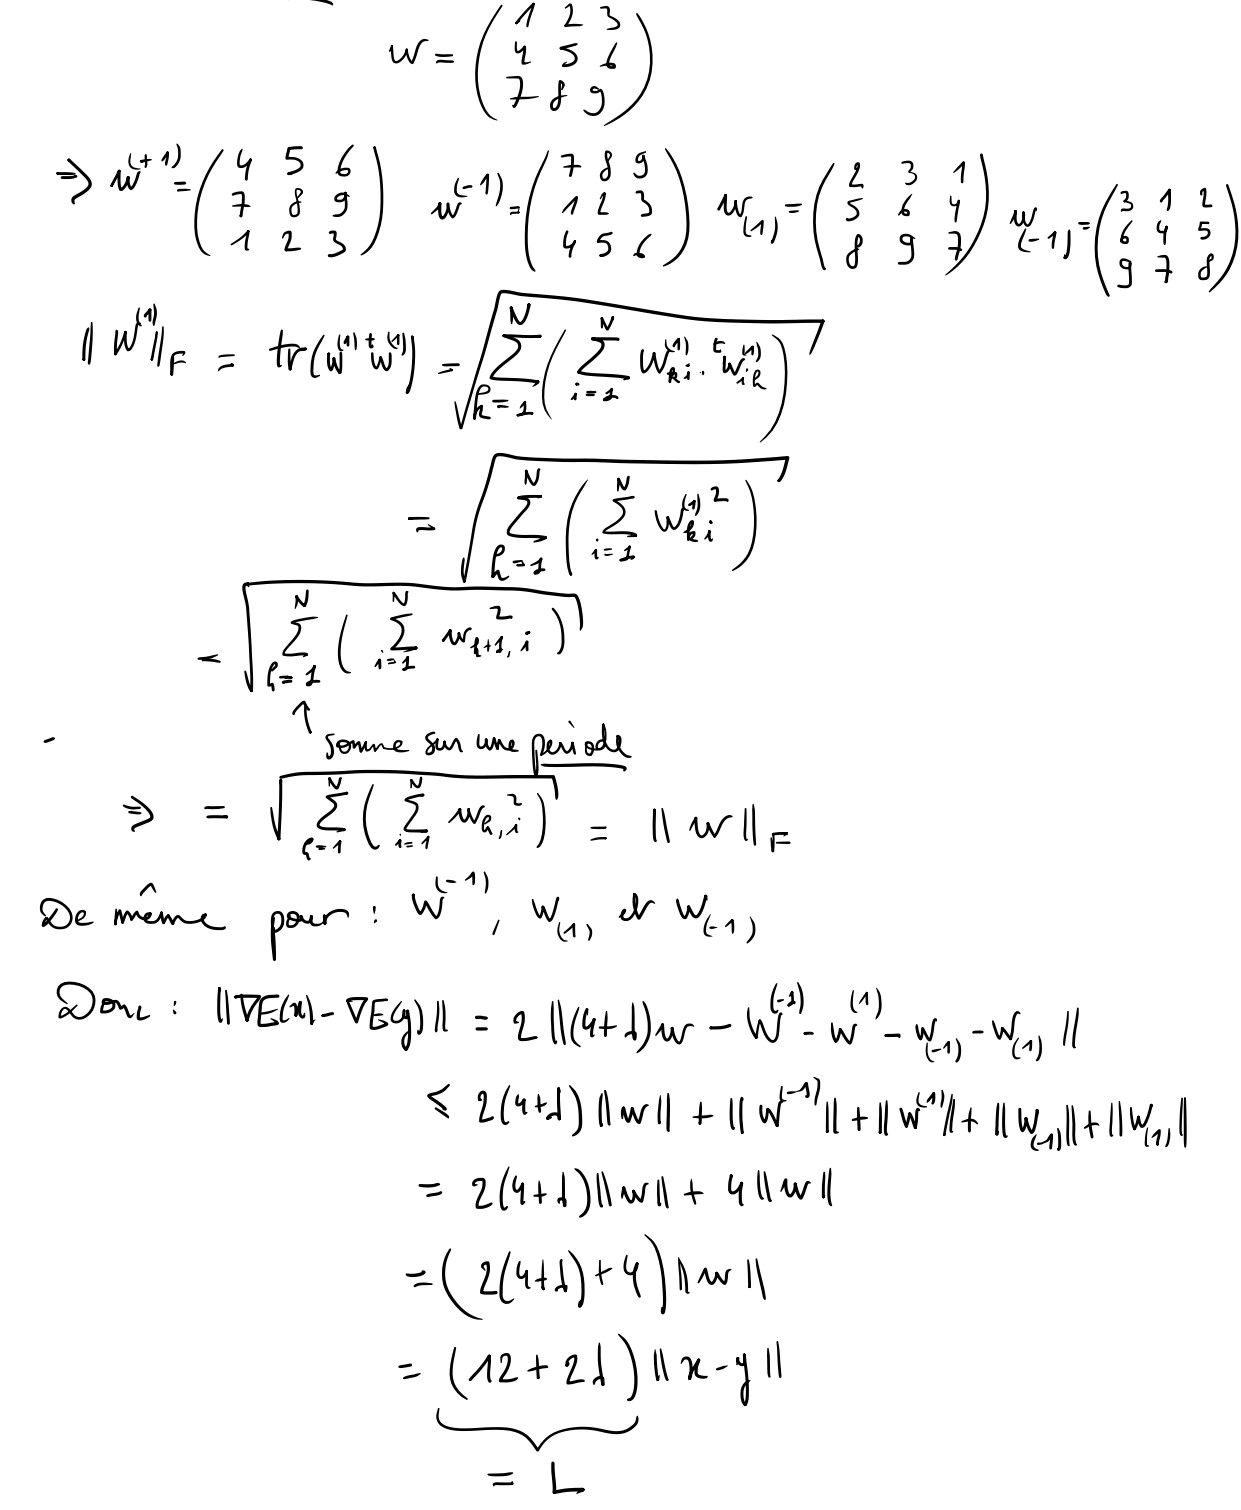